# 2020 Covid dataset analysed


## Part 1 - Feature Engineering 

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt

In [275]:
list_of_df= []
for (root, dirs, files) in os.walk(os.path.join(os.getcwd(), "county_data")):
    for file in files:
        if file[-4:] == ".csv": 
            df = pd.read_csv(os.path.join(root, file))
            df = df.dropna()
            if len(df):
                name = df["areaName"][5]
                df = df.drop(df.columns[:3], axis=1)[::-1].reset_index(drop=True)
                df['y'] = df["newCasesBySpecimenDate"]/df["newVirusTestsBySpecimenDate"]
                for i in range(len(df)):
                        if df["newVirusTestsBySpecimenDate"][i]==0:
                            df.loc[i, 'y']=0
                df.columns=['Date','Cases','Deaths','Tests','y']
                df=df.set_index('Date')
                list_of_df.append((name,df))




In [3]:
list_of_df[0][1]

,Cases,Deaths,Tests,y
Date,,,,
2020-03-20,1.0,1.0,4,0.250000
2020-03-21,0.0,1.0,5,0.000000
2020-03-22,0.0,0.0,9,0.000000
2020-03-23,0.0,0.0,11,0.000000
2020-03-24,0.0,0.0,11,0.000000
...,...,...,...,...
2022-11-10,11.0,0.0,66,0.166667
2022-11-11,0.0,0.0,45,0.000000
2022-11-12,5.0,0.0,176,0.028409


## Part 2 - Deep Learning 

In [82]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
moving_average([1, 2, 1, 4, 50, 6, 7], 5)

array([ 1.33333333,  2.33333333, 18.33333333, 20.        , 21.        ])

In [355]:
past_values = 100
def get_data(n):
    values=list(list_of_df[n][1].y)
    X = []
    y = []
    for i in range(len(values)-past_values):
        X.append(values[i:i+past_values])
        y.append(values[i+past_values])
    X = np.array(X[2:-2])
    y = moving_average(np.array(y), 5)
    return X, y

In [310]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='tanh', input_shape=(past_values, )),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')]
)
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mae')

In [320]:
for _ in range(10):
    for i in range(len(list_of_df)):
        X, y = get_data(i)
        model.fit(X[:300], y[:300], epochs=1, verbose=0)

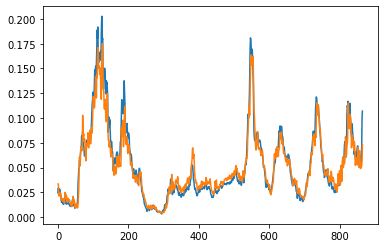

In [359]:
X, y = get_data(55)
y_pred = model.predict(X)
plt.plot(y)
plt.plot(y_pred)

In [372]:
def predict_future(n, steps, timeline):
    size = len(timeline)
    for i in range(steps):
        y_pred = model.predict(np.array([timeline[-size:]]))
        timeline = np.append(timeline, y_pred)
    return timeline[-steps:]

In [373]:
n=55
steps = 30
X, y = get_data(n)
y=y[-350:]
y_future = predict_future(n, steps, X[-1])
# x_axis_future = np.arange(len(y), len(y)+steps)
# plt.plot(y)
# plt.plot(x_axis_future, y_future)

In [340]:
model.save("model2")

INFO:tensorflow:Assets written to: model2\assets
